In [1]:
import seaborn as sbn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
from pathlib import Path
import sys
dir_path = '/home/nnieto/Nico/Harmonization/harmonize_project/3_check_results/'
__file__ = dir_path+'plot_NM.py'
to_append = Path(__file__).resolve().parent.parent.as_posix()
sys.path.append(to_append)

from lib.utils import extract_experiment_data # noqa
from lib.utils import table_generation # noqa
from lib.utils import get_fold_acc_auc, classification_table # noqa

# Site-target dependant
## Age regression

In [4]:

exp_dir = "/home/nnieto/Nico/Harmonization/harmonize_project/scratch/output/"


methods = ["cheat", "none", "juharmonize","leak","notarget"]
results_method = pd.DataFrame()
results = pd.DataFrame()
for method in methods:
    results_method = pd.DataFrame()

    print(method)

    results_method["y_pred"] = pd.read_csv(exp_dir+ "y_pred_"+method+".csv", index_col=0).dropna(axis=1).to_numpy().ravel()

    
    results_method["y_true"] = pd.read_csv(exp_dir+ "y_true.csv", index_col=0).dropna(axis=1).to_numpy().ravel()
    results_method["site"] = pd.read_csv(exp_dir+ "sites.csv", index_col=0).dropna(axis=1).to_numpy().ravel()

    results_method["y_diff"] = (results_method["y_true"]-results_method["y_pred"])
    results_method["Harmonization Scheme"] = method
    results = pd.concat([results,results_method])




cheat
none
juharmonize
leak
notarget


/tmp/ipykernel_44127/3225016517.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results["Harmonization Scheme"].replace({"juharmonize": "PrettYharmonize",
/tmp/ipykernel_44127/3225016517.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].metho

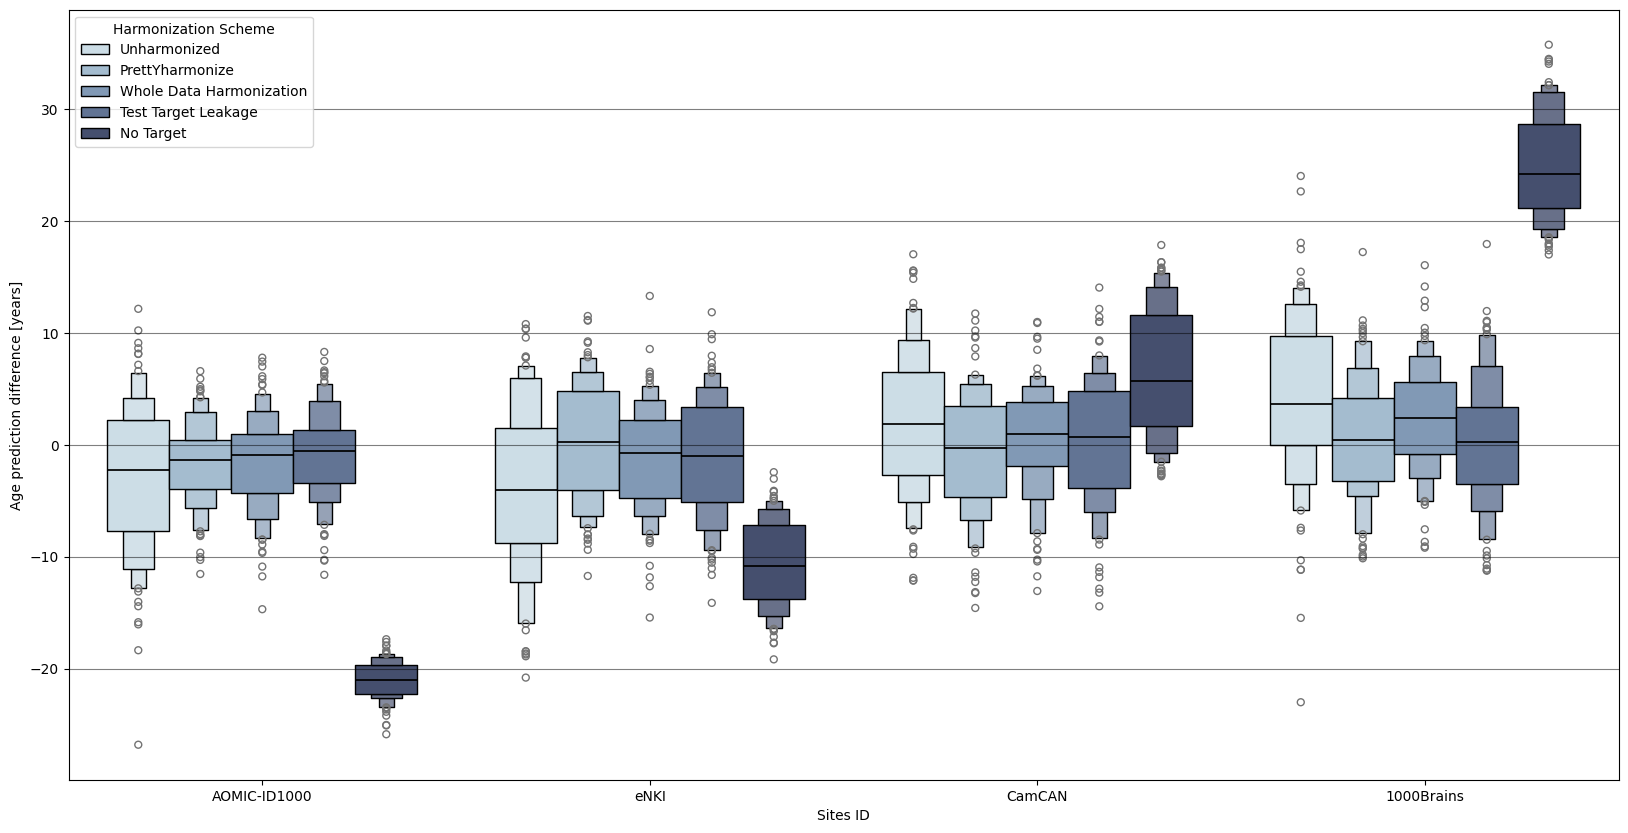

In [5]:
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
pal = sbn.cubehelix_palette(5, rot=-.15, light=0.85, dark=0.3, gamma=1)
harm_modes = ["Unharmonized", "PrettYharmonize", "Whole Data Harmonization", "Test Target Leakage",  "No Target"]


results["Harmonization Scheme"].replace({"juharmonize": "PrettYharmonize",
                                "leak": "Test Target Leakage",
                                "none": "Unharmonized",
                                "cheat": "Whole Data Harmonization",
                                "notarget": "No Target"}, inplace=True)

results["site"].replace({0: "AOMIC-ID1000",
                                1: "eNKI",
                                2: "CamCAN",
                                3: "1000Brains",}, inplace=True)
# sbn.boxenplot(
#     data=results,
#     x="site", y="y_diff", hue="Harmonization Scheme",
#     outlier_prop = 1,
#     palette=sbn.color_palette("muted"),
#     linecolor="black",
#     hue_order=harm_modes,
#     linewidth=1
# )
sbn.boxenplot(
    data=results,
    x="site", y="y_diff", hue="Harmonization Scheme",
    outlier_prop = 1,
    palette=pal,
    linecolor="black",
    hue_order=harm_modes,
    linewidth=1
)
plt.ylabel("Age prediction difference [years]")
plt.xlabel("Sites ID")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

/tmp/ipykernel_5640/3618201440.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sbn.barplot(


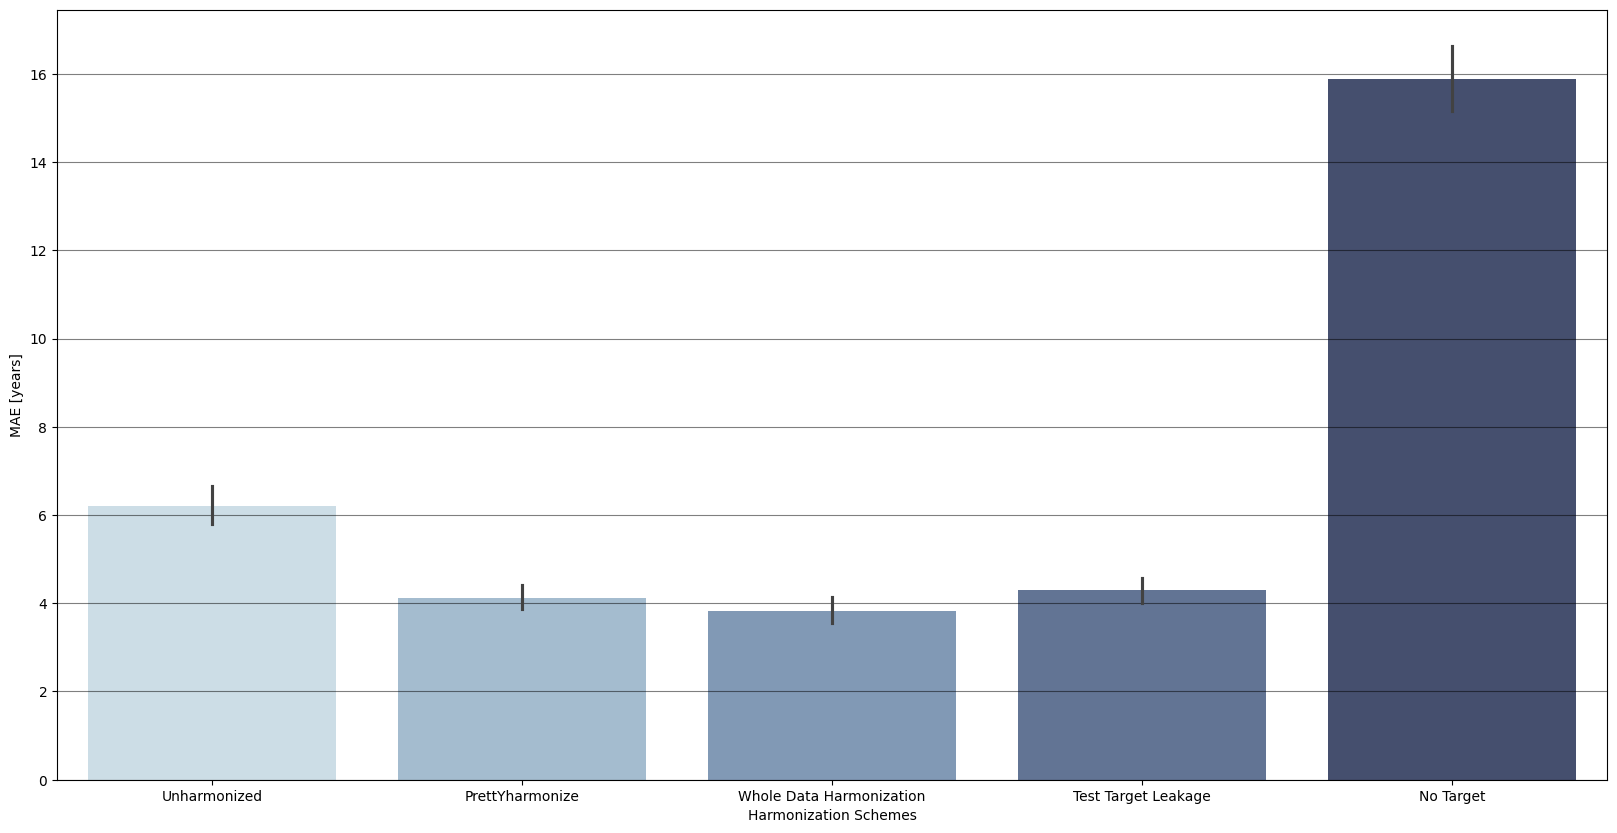

In [4]:
results["y_diff_abs"] = np.abs(results["y_diff"])
fig, ax = plt.subplots(1, 1, figsize=[20, 10])

ax = sbn.barplot(
    data=results, 
    x="Harmonization Scheme", y="y_diff_abs",
    order=harm_modes,
    palette=pal
)

plt.ylabel("MAE [years]")
plt.xlabel("Harmonization Schemes")
plt.grid(alpha=0.5, axis="y", c="black")

In [9]:
results = pd.read_csv("/home/nnieto/Nico/Harmonization/harmonize_project/scratch/output/results/results_age_regression_balanced_disjoint_ranges.csv")

results.rename(columns={"Harmonization Scheme":"Harmonization Schemes"}, inplace=True)

# Get Harmonizations modes
harm_modes = np.unique(results["Harmonization Schemes"])
# Initialize a table as a dataframe
table = pd.DataFrame(columns=harm_modes, index=["MAE", "R2", "Age bias"])

# Iterate over each mode
for mode in harm_modes:
    resut_mode = results[results["Harmonization Schemes"] == mode]
    final_stat = resut_mode.mean(numeric_only=True)
    table[mode] = final_stat["MAE"],final_stat["R2"],final_stat["Age bias"]

print(table)

          Cheat Test  JuHarmonize Test  Leakage Test  No Target Test  \
MAE         3.827402          4.120185      4.287193       15.938492   
R2          0.925738          0.919463      0.912036       -0.007474   
Age bias   -0.321290         -0.264923     -0.238011       -0.998774   

          None Test  
MAE        6.200548  
R2         0.813226  
Age bias  -0.433264  


## Sex classification

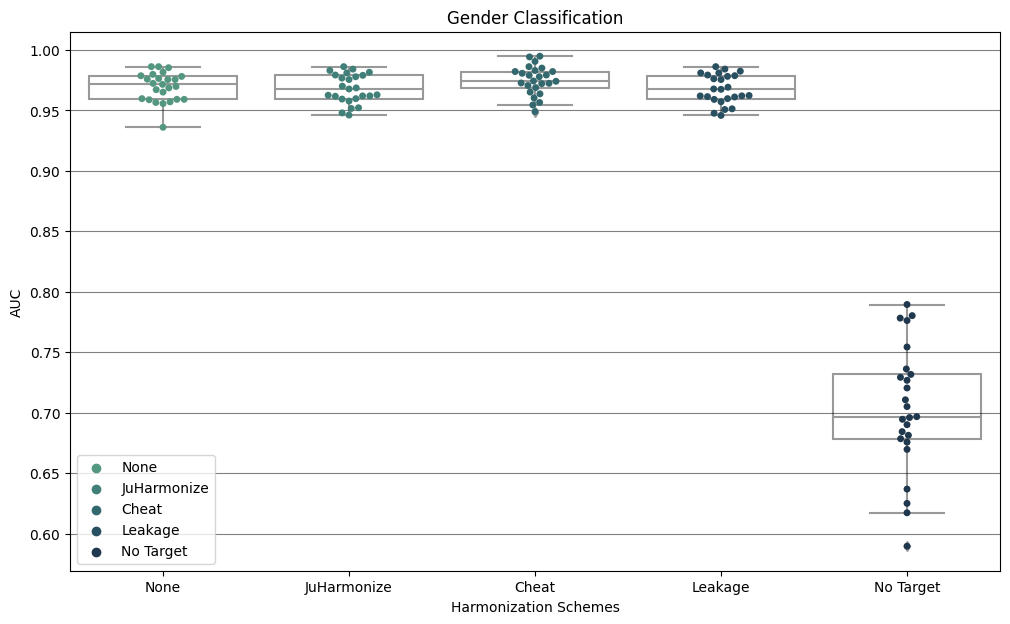

In [31]:
results = pd.read_csv("/home/nnieto/Nico/Harmonization/results_classification/test_imbalanced_genders_lg_pred_lg_stack/results_all_methods.csv")

results.rename(columns={"Model": "Harmonization Schemes"},
            inplace=True)
harm_methods = ["JuHarmonize Test", "Cheat Test", "Leakage Test", "No Target Test", "None Test"]

results = results[results["Harmonization Schemes"].isin(harm_methods)]

# Change to appropiated names
results["Harmonization Schemes"].replace({"JuHarmonize Test": "JuHarmonize",
                                       "Leakage Test": "Leakage",
                                       "None Test": "None",
                                       "Cheat Test": "Cheat",
                                       "No Target Test": "No Target"},
                                      inplace=True)

# Select methods to plot
harm_modes = ["None", "JuHarmonize", "Cheat", "Leakage" ,  "No Target"]
metric_to_plot = "AUC"

# Plot
pal = sbn.cubehelix_palette(5, rot=-.5, light=0.5, dark=0.2)
_, ax = plt.subplots(1, 1, figsize=[12, 7])
sbn.swarmplot(
    data=results,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    palette=pal,
    hue_order=harm_modes,
    order=harm_modes, dodge=False, ax=ax
)
sbn.boxplot(
    data=results, color="w", zorder=1,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    order=harm_modes, dodge=False, ax=ax, palette=["w"]*len(harm_modes)
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(harm_modes)], labels[:len(harm_modes)],
          loc='lower left')
plt.ylabel(metric_to_plot)
plt.xlabel("Harmonization Schemes")
plt.title("Gender Classification")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

In [11]:
table = pd.DataFrame(columns=harm_modes, index=["AUC", "Balanced ACC", "F1"])

# Iterate over each mode
for mode in harm_modes:
    resut_mode = results[results["Harmonization Schemes"] == mode]
    final_stat = resut_mode.mean(numeric_only=True)
    table[mode] = final_stat["AUC"],final_stat["Balanced ACC"],final_stat["F1"]

print(table)

              JuHarmonize     Cheat   Leakage      None  No Target
AUC              0.967863  0.974772  0.967495  0.969441   0.702960
Balanced ACC     0.921823  0.920979  0.920724  0.926430   0.630785
F1               0.918013  0.916863  0.916766  0.922617   0.607571


# Demencia-MCI classification

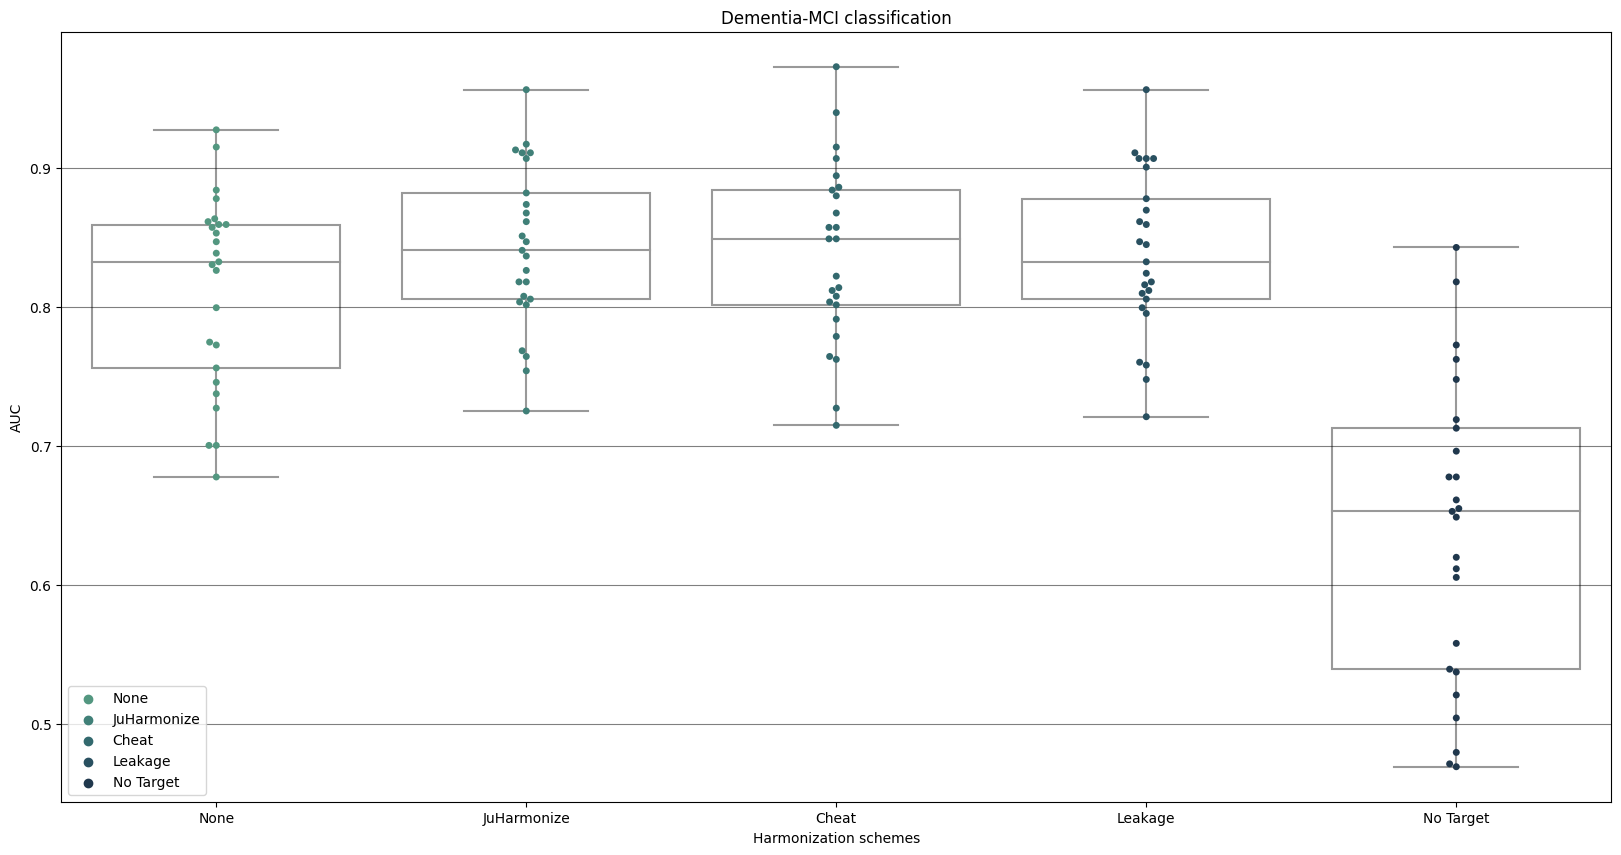

In [33]:

import pandas as pd
import seaborn as sbn
data_dir = "/home/nnieto/Nico/Harmonization/harmonize_project/scratch/output/results/Kersten/"
data = pd.read_csv(data_dir+"Kersten_results_dependance.csv")
models_to_plot = ["JuHarmonize Test", "Cheat Test", "Leakage Test", "None Test","No Target Test"]

# Select methods to plot
data = data[data["Model"].isin(models_to_plot)]
data["Model"].replace({"JuHarmonize Test": "JuHarmonize",
                                "Cheat Test": "Cheat",
                                "Leakage Test": "Leakage",
                                "No Target Test": "No Target",
                                "None Test": "None"}, inplace=True)
models_to_plot = ["None", "JuHarmonize", "Cheat", "Leakage" ,"No Target"]

data.rename(columns={"Model":"Harmonization Schemes"}, inplace=True)
harm_modes = models_to_plot
metric_to_plot = "AUC"
import matplotlib.pyplot as plt
# Plot
# Plot
pal = sbn.cubehelix_palette(5, rot=-.5, light=0.5, dark=0.2)
_, ax = plt.subplots(1, 1, figsize=[20, 10])
sbn.swarmplot(
    data=data,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    palette=pal,
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax
)
sbn.boxplot(
    data=data, color="w", zorder=1,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax, palette=["w"]*len(harm_modes)
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[:len(harm_modes)], labels[:len(harm_modes)],
          loc='lower left')
plt.ylabel(metric_to_plot)
# plt.ylim([0.45,0.78])

plt.xlabel("Harmonization schemes")
plt.title("Dementia-MCI classification")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

In [34]:
table = pd.DataFrame(columns=harm_modes, index=["AUC", "Balanced ACC", "F1"])
results = data
# Iterate over each mode
for mode in harm_modes:
    resut_mode = results[results["Harmonization Schemes"] == mode]
    final_stat = resut_mode.mean(numeric_only=True)
    table[mode] = round(final_stat["AUC"],4),round(final_stat["Balanced ACC"]*100,4),round(final_stat["F1"],4)

print(table)

                 None  JuHarmonize    Cheat  Leakage  No Target
AUC            0.8131       0.8429   0.8385   0.8381     0.6384
Balanced ACC  73.7273      77.2727  76.6364  76.3636    60.1818
F1             0.7371       0.7715   0.7644   0.7622     0.6054


# eICU dataset

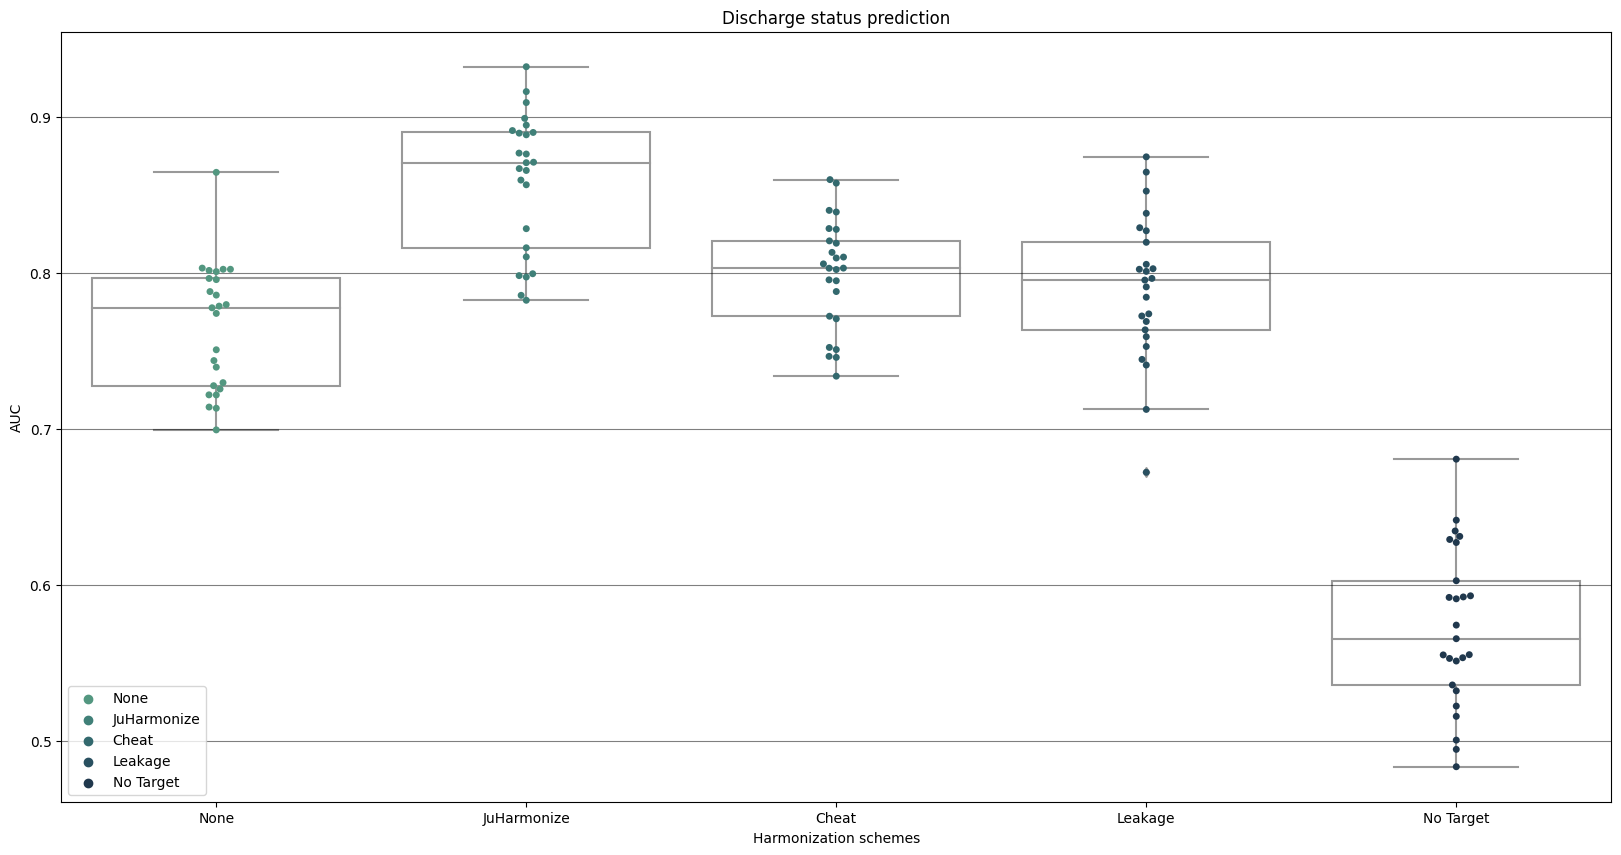

In [11]:
data_dir = "/home/nnieto/Nico/Harmonization/harmonize_project/scratch/output/results/sepsis_classification_eicu/"
data = pd.read_csv(data_dir+"eiCU_results_dependance.csv")
models_to_plot = ["JuHarmonize Test", "Cheat Test", "Leakage Test", "None Test","No Target Test"]

# Select methods to plot
data = data[data["Model"].isin(models_to_plot)]
data["Model"].replace({"JuHarmonize Test": "JuHarmonize",
                                "Cheat Test": "Cheat",
                                "Leakage Test": "Leakage",
                                "No Target Test": "No Target",
                                "None Test": "None"}, inplace=True)
models_to_plot = ["None", "JuHarmonize", "Cheat", "Leakage" ,"No Target"]

data.rename(columns={"Model":"Harmonization Schemes"}, inplace=True)
harm_modes = models_to_plot
metric_to_plot = "AUC"
import matplotlib.pyplot as plt
# Plot
# Plot
pal = sbn.cubehelix_palette(5, rot=-.5, light=0.5, dark=0.2)
_, ax = plt.subplots(1, 1, figsize=[20, 10])
sbn.swarmplot(
    data=data,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    palette=pal,
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax
)
sbn.boxplot(
    data=data, color="w", zorder=1,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax, palette=["w"]*len(harm_modes)
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[:len(harm_modes)], labels[:len(harm_modes)],
          loc='lower left')
plt.ylabel(metric_to_plot)

plt.ylabel(metric_to_plot)
plt.xlabel("Harmonization schemes")
plt.title("Discharge status prediction")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

In [9]:
table = pd.DataFrame(columns=harm_modes, index=["AUC", "Balanced ACC", "F1"])
results = data
# Iterate over each mode
for mode in harm_modes:
    resut_mode = results[results["Harmonization Schemes"] == mode]
    final_stat = resut_mode.mean(numeric_only=True)
    table[mode] = round(final_stat["AUC"],4),round(final_stat["Balanced ACC"]*100,4),round(final_stat["F1"],4)

print(table)

              JuHarmonize    Cheat  Leakage     None  No Target
AUC                0.8588   0.7995   0.7897   0.7655     0.5723
Balanced ACC      66.2452  63.3959  63.9118  64.3764    51.6681
F1                 0.4910   0.4408   0.4517   0.4571     0.0921


# Site-target independant

In [17]:
exp_dir = "/home/nnieto/Nico/Harmonization/results_regression/"
experiments_to_check = {'test_regression_balanced_data_rvr_stack_rvr_pred'}
data = extract_experiment_data(exp_dir, experiments_to_check, train=False)
data.rename(columns={"harmonize_mode": "Harmonization Schemes"},
            inplace=True)

data["Harmonization Schemes"].replace({"pretend": "PrettYharmonize",
                                "target": "Test Target Leakage",
                                "none": "Unharmonized",
                                "cheat": "Whole Data Harmonization",
                                "notarget": "No Target"}, inplace=True)
data

,Unnamed: 0,y_true,y_pred,site,Harmonization Schemes,fold,repeat
0,0,20.0,32.998628,eNKI,Test Target Leakage,0,1
1,1,22.0,19.289152,eNKI,Test Target Leakage,0,1
2,2,21.0,26.653731,eNKI,Test Target Leakage,0,1
3,3,24.0,24.210965,eNKI,Test Target Leakage,0,1
4,4,28.0,31.480022,eNKI,Test Target Leakage,0,1
...,...,...,...,...,...,...,...
150,150,70.0,61.940697,SALD,Whole Data Harmonization,1,1
151,151,75.0,68.423137,SALD,Whole Data Harmonization,1,1
152,152,74.0,65.958285,SALD,Whole Data Harmonization,1,1
153,153,73.0,65.277197,SALD,Whole Data Harmonization,1,1


/tmp/ipykernel_5640/3357211899.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Harmonization Schemes"].replace({"pretend": "PrettYharmonize",


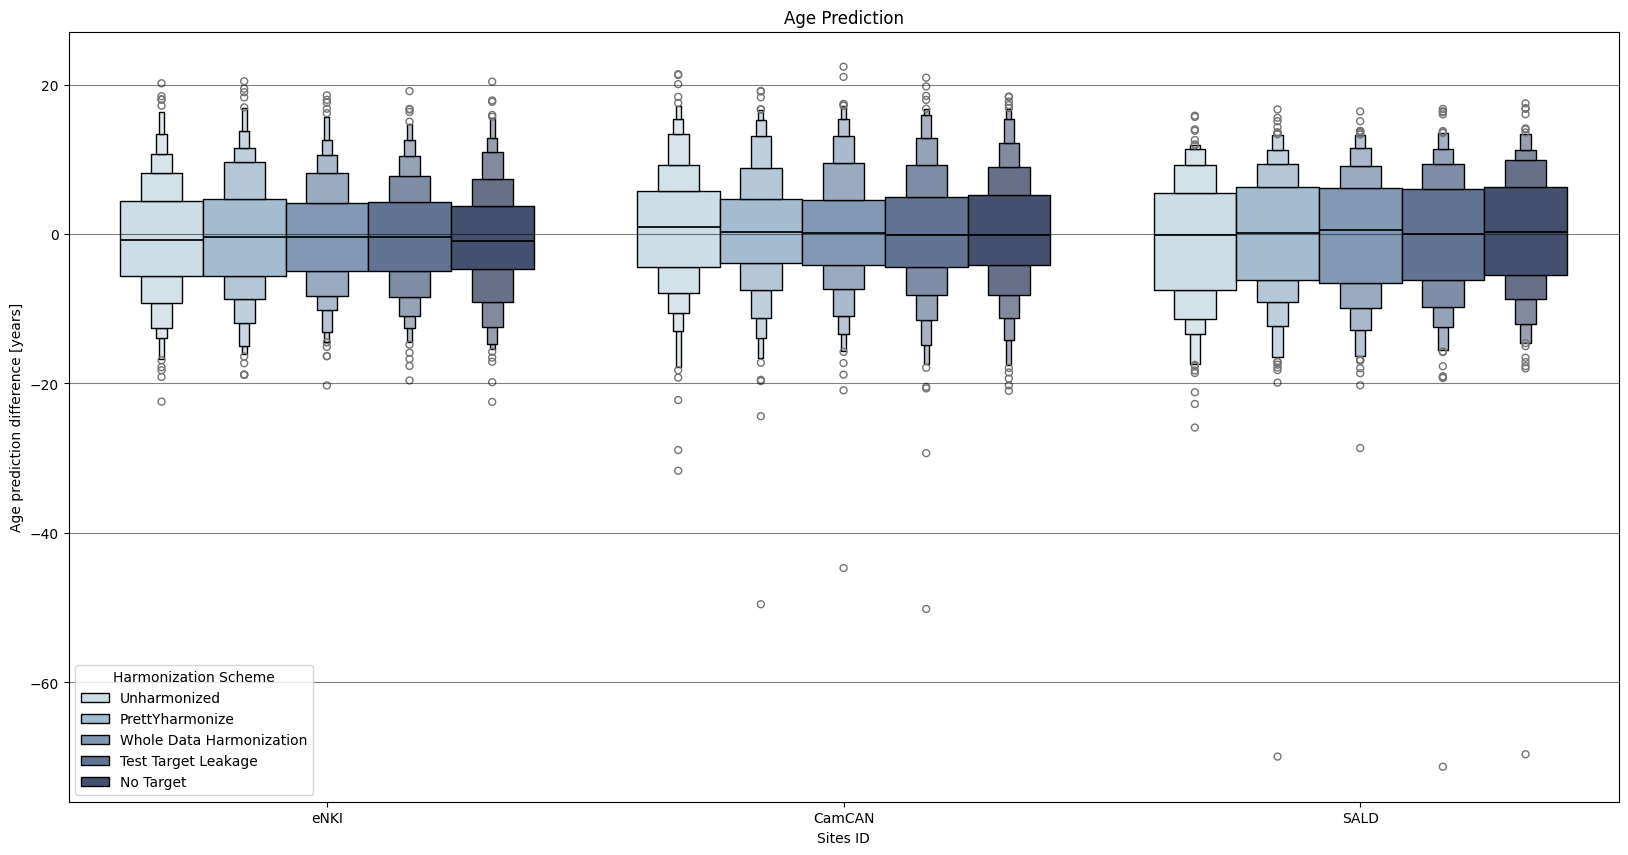

In [50]:
exp_dir = "/home/nnieto/Nico/Harmonization/results_regression/"
experiments_to_check = {'test_regression_balanced_data_rvr_stack_rvr_pred'}
data = extract_experiment_data(exp_dir, experiments_to_check, train=False)
data.rename(columns={"harmonize_mode": "Harmonization Schemes"},
            inplace=True)

data["Harmonization Schemes"].replace({"pretend": "PrettYharmonize",
                                "target": "Test Target Leakage",
                                "none": "Unharmonized",
                                "cheat": "Whole Data Harmonization",
                                "notarget": "No Target"}, inplace=True)

harm_modes = ["Unharmonized", "PrettYharmonize", "Whole Data Harmonization", "Test Target Leakage",  "No Target"]


data = data[data["Harmonization Schemes"].isin(harm_modes)]
data.rename(columns={"Harmonization Schemes":"Harmonization Scheme"}, inplace=True)
absolute = False

if absolute:
    data["y_diff"] = np.abs(data["y_true"]-data["y_pred"])
else:
    data["y_diff"] = data["y_true"]-data["y_pred"]

fig, ax = plt.subplots(1, 1, figsize=[20, 10])
pal = sbn.cubehelix_palette(5, rot=-.15, light=0.85, dark=0.3)

sbn.boxenplot(
    data=data,
    x="site", y="y_diff", hue="Harmonization Scheme",
    outlier_prop = 1,
    palette=pal,
    linecolor="black",
    hue_order=harm_modes,
    linewidth=1
)
plt.ylabel("Age prediction difference [years]")
plt.title("Age Prediction")
plt.xlabel("Sites ID")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()



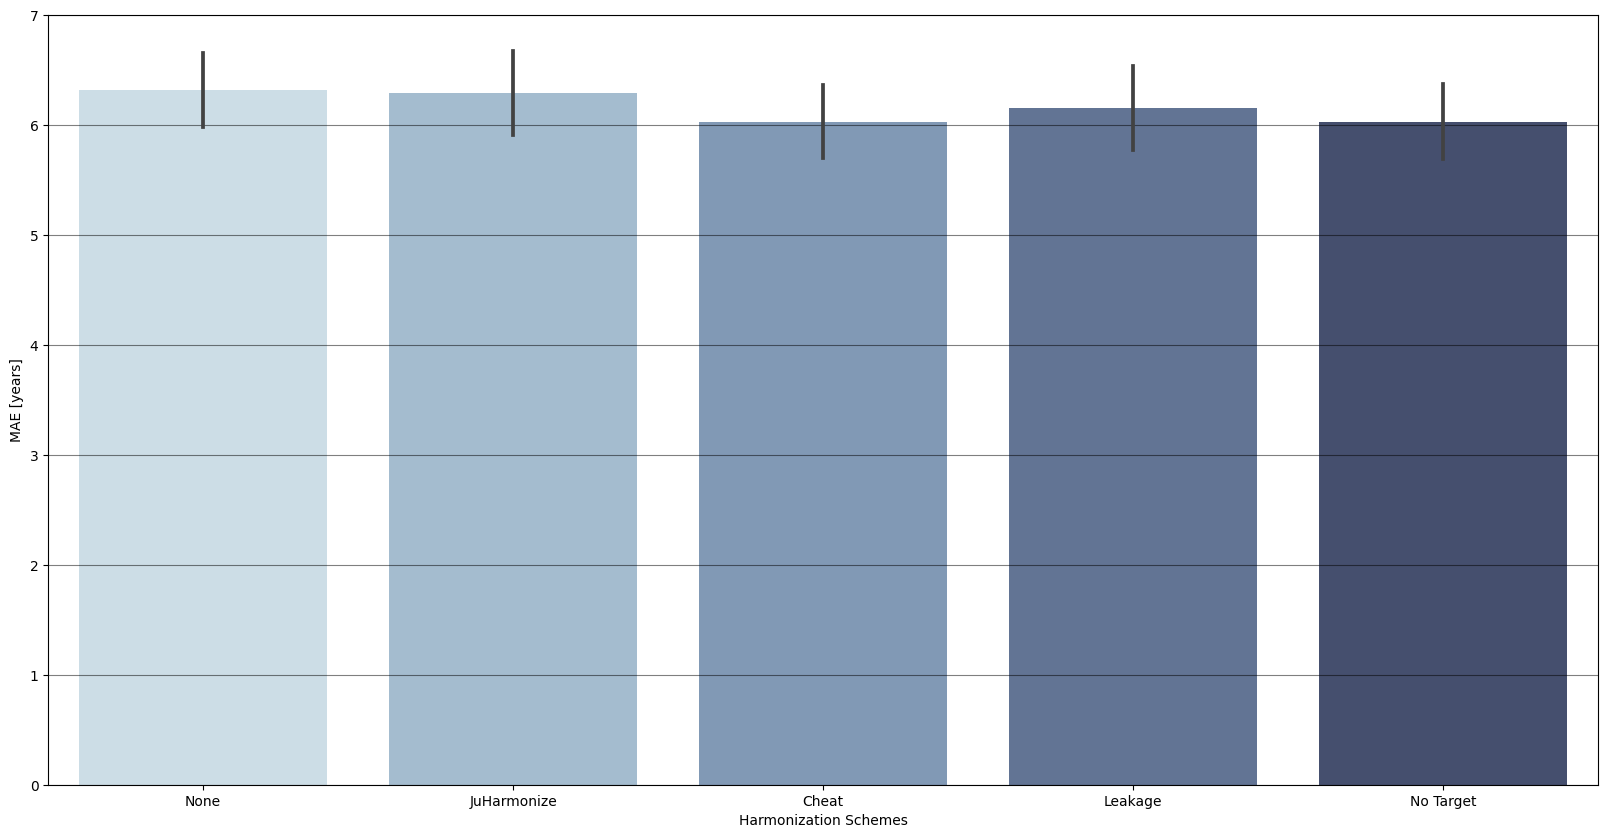

In [36]:
data["y_diff"] = np.abs(data["y_true"]-data["y_pred"])
data = data[data["Harmonization Schemes"].isin(harm_modes)]

fig = plt.figure(figsize=[20, 10])

ax = fig.add_subplot(1, 1, 1)
pal = sbn.cubehelix_palette(5, rot=-.15, light=0.85, dark=0.3)

ax = sbn.barplot(
    data=data,
    x="Harmonization Schemes", y="y_diff",
    order=harm_modes, ax=ax,
    palette=pal, seed=23, n_boot=1000
)
plt.ylabel("MAE [years]")
plt.xlabel("Harmonization Schemes")

plt.grid(alpha=0.5, axis="y", c="black")

plt.show()

In [14]:
table = table_generation(data)
print(table)

             Age_bias        R2       MAE
Cheat       -0.366155  0.803460  6.034794
JuHarmonize -0.423953  0.769231  6.306701
Leakage     -0.319046  0.775501  6.153351
No Target   -0.341006  0.790369  6.036082
None        -0.361386  0.785301  6.314433


In [ ]:

if absolute:
    data["y_diff"] = np.abs(data["y_true"]-data["y_pred"])
else:
    data["y_diff"] = data["y_true"]-data["y_pred"]


hue_order = ['AOMIC-ID1000', 'eNKI', 'CamCAN', '1000Brains',]
for harm_to_plot in harm_modes:
    data_to_plot = data[data["Harmonization Schemes"] == harm_to_plot]
    fig, ax = plt.subplots(1, 1, figsize=[20, 10])
    pal = sbn.cubehelix_palette(5, rot=-.15, light=0.85, dark=0.3)
    sbn.scatterplot(
        data=data_to_plot,
        x="y_true", y="y_pred", hue="site", hue_order=hue_order
    )
    plt.ylabel("Predicted Age")
    MAE = mean_absolute_error(data_to_plot["y_true"],data_to_plot["y_pred"])
    plt.title(harm_to_plot + "- Age Prediction - MAE: " + str(MAE))
    plt.xlabel("True Age")
    age_range_y = [0,95]
    grid_distance = 10
    plt.yticks(np.arange(age_range_y[0], age_range_y[1], grid_distance))
    plt.grid(alpha=0.5, which="both", axis="y", c="black", linestyle="--")
    plt.legend([],framealpha=0)
    age_range = [18,87]
    plt.xlim(age_range)

    plt.ylim(age_range_y)
    sbn.lineplot(x=age_range, y=age_range)
    plt.show()


## Sex classification


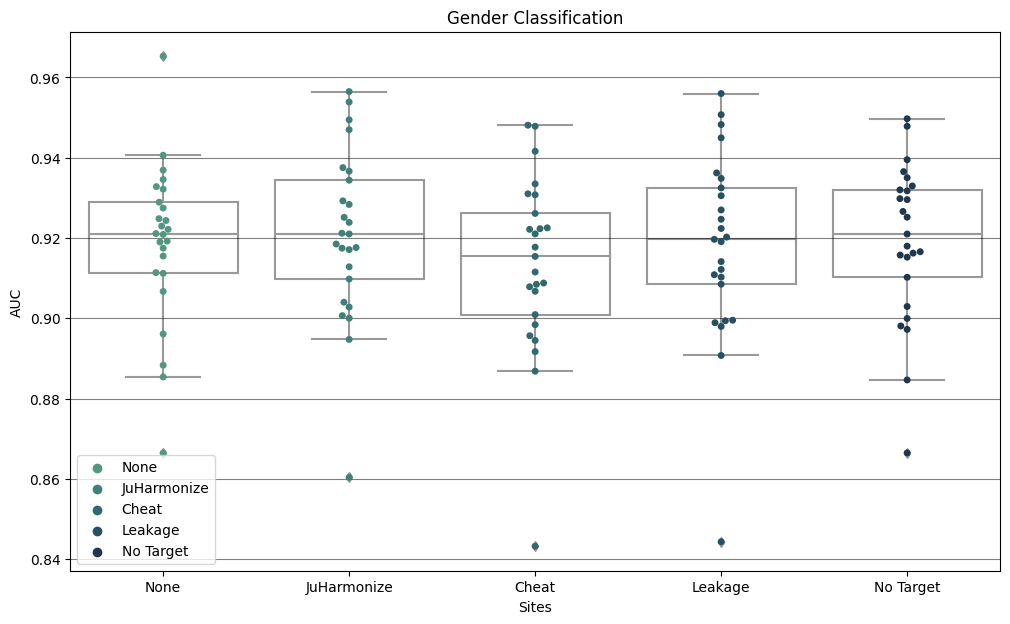

In [37]:
exp_dir = "/home/nnieto/Nico/Harmonization/results_classification/"
experiments_to_check = {
    'test_classification_balanced_data_logit_stack_gssvm_pred_5repetitions'
}
# Get results
data = extract_experiment_data(exp_dir, experiments_to_check, False)
data.rename(columns={"harmonize_mode": "Harmonization Schemes"},
            inplace=True)
data = get_fold_acc_auc(data)
# Change to appropiated names
data["Harmonization Schemes"].replace({"pretend": "JuHarmonize",
                                       "target": "Leakage",
                                       "none": "None",
                                       "cheat": "Cheat",
                                       "predict": "NeuroHarmony",
                                       "notarget": "No Target"},
                                      inplace=True)

# Select methods to plot
harm_modes = ["None", "JuHarmonize", "Cheat", "Leakage","No Target"]
data = data[data["Harmonization Schemes"].isin(harm_modes)]
data = data[data["site"].isin(["Global"])]

# site_order = ["Global", "eNKI", "CamCAN"]
metric_to_plot = "AUC"

# Plot
pal = sbn.cubehelix_palette(5, rot=-.5, light=0.5, dark=0.2)
_, ax = plt.subplots(1, 1, figsize=[12, 7])
sbn.swarmplot(
    data=data,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    palette=pal,
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax
)
sbn.boxplot(
    data=data, color="w", zorder=1,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax, palette=["w"]*len(harm_modes)
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(harm_modes)], labels[:len(harm_modes)],
          loc='lower left')
plt.ylabel(metric_to_plot)
plt.xlabel("Sites")
plt.title("Gender Classification")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

In [16]:
table = pd.DataFrame(columns=harm_modes, index=["AUC", "Balanced ACC", "F1"])
results = data
# Iterate over each mode
for mode in harm_modes:
    resut_mode = results[results["Harmonization Schemes"] == mode]
    final_stat = resut_mode.mean(numeric_only=True)
    table[mode] = final_stat["AUC"],final_stat["Balanced Accuracy"],final_stat["F1"]

print(table)


              JuHarmonize   Leakage     Cheat      None  No Target
AUC              0.920806  0.918152  0.913386  0.918872   0.919150
Balanced ACC     0.850609  0.851619  0.846380  0.849389   0.848534
F1               0.851088  0.852031  0.847230  0.851855   0.849066


# Demencia-MCI

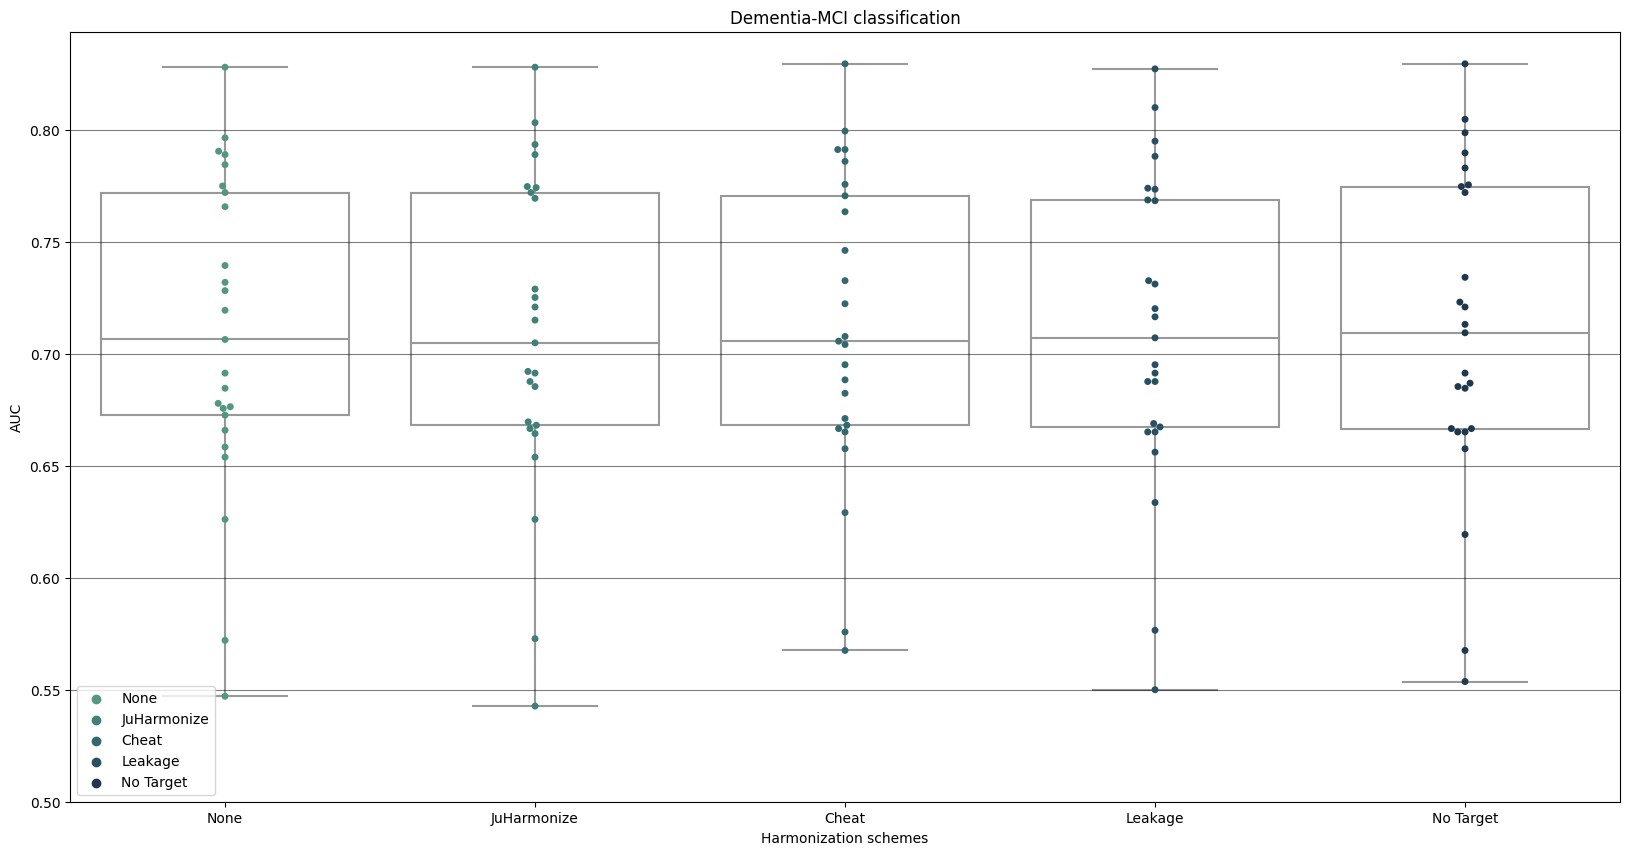

In [38]:

import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

data_dir = "/home/nnieto/Nico/Harmonization/harmonize_project/scratch/output/results/Kersten/"
data = pd.read_csv(data_dir+"Kersten_results_independance.csv")
models_to_plot = ["JuHarmonize Test", "Cheat Test", "Leakage Test", "None Test","No Target Test"]

# Select methods to plot
data = data[data["Model"].isin(models_to_plot)]
data["Model"].replace({"JuHarmonize Test": "JuHarmonize",
                                "Cheat Test": "Cheat",
                                "Leakage Test": "Leakage",
                                "No Target Test": "No Target",
                                "None Test": "None"}, inplace=True)
models_to_plot = ["None","JuHarmonize", "Cheat", "Leakage", "No Target"]

data.rename(columns={"Model":"Harmonization Schemes"}, inplace=True)
harm_modes = models_to_plot
metric_to_plot = "AUC"
# Plot
# Plot
pal = sbn.cubehelix_palette(5, rot=-.5, light=0.5, dark=0.2)
_, ax = plt.subplots(1, 1, figsize=[20, 10])
sbn.swarmplot(
    data=data,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    palette=pal,
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax
)
sbn.boxplot(
    data=data, color="w", zorder=1,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax, palette=["w"]*len(harm_modes)
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[:len(harm_modes)], labels[:len(harm_modes)],
          loc='lower left')
plt.ylabel(metric_to_plot)
plt.ylim(0.5)
plt.xlabel("Harmonization schemes")
plt.title("Dementia-MCI classification")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

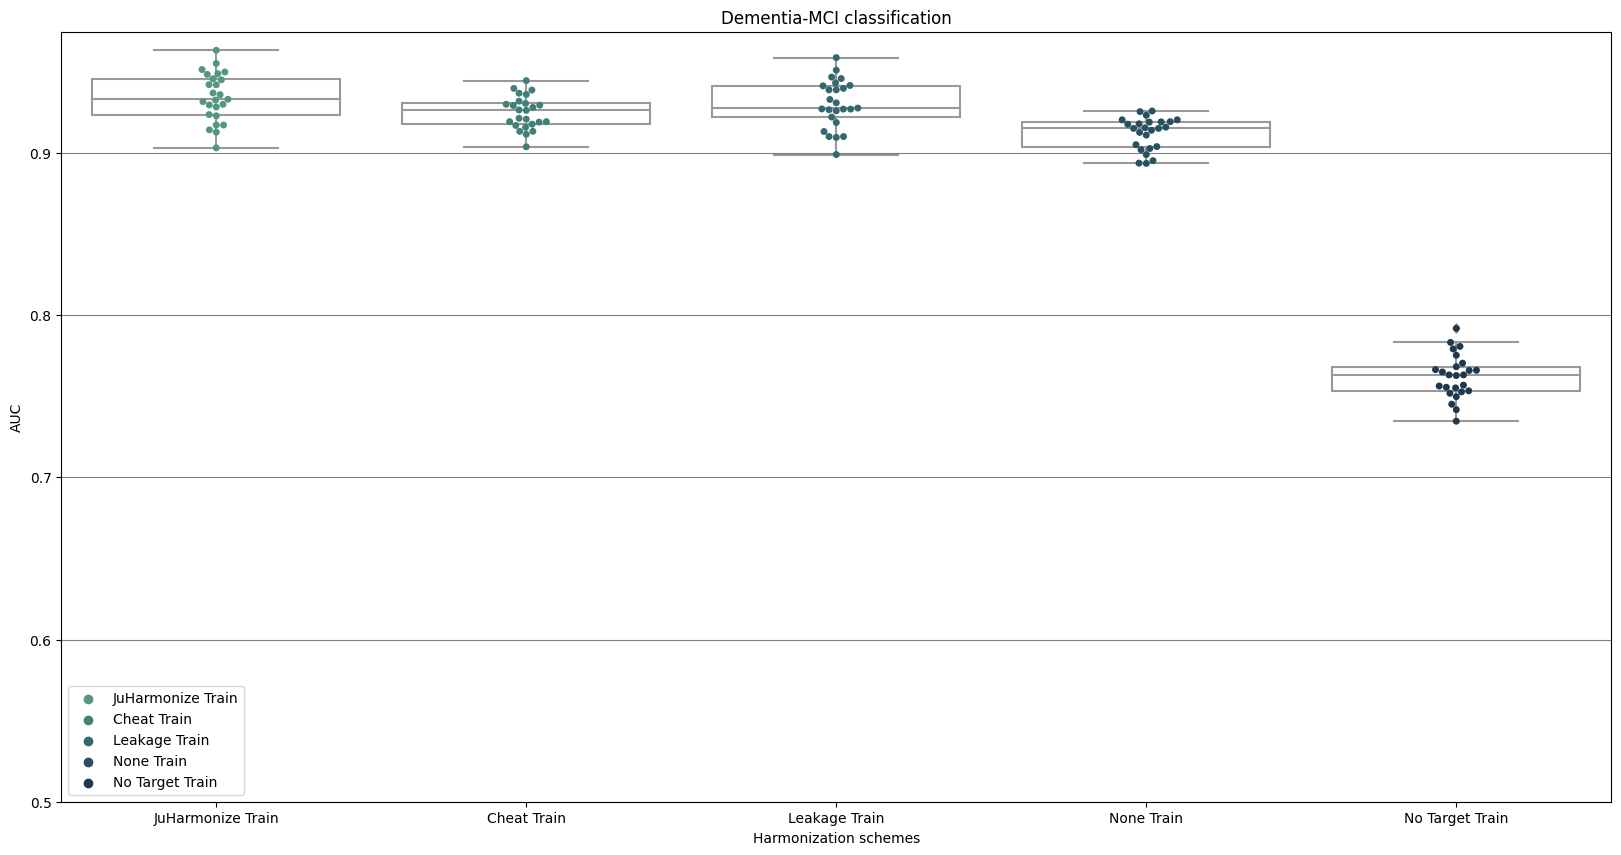

In [1]:

import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

data_dir = "/home/nnieto/Nico/Harmonization/harmonize_project/scratch/output/results/Kersten/"
data = pd.read_csv(data_dir+"Kersten_results_dependance.csv")
models_to_plot = ["JuHarmonize Train", "Cheat Train", "Leakage Train", "None Train","No Target Train"]

# Select methods to plot
data = data[data["Model"].isin(models_to_plot)]
data["Model"].replace({"JuHarmonize Test": "JuHarmonize",
                                "Cheat Test": "Cheat",
                                "Leakage Test": "Leakage",
                                "No Target Test": "No Target",
                                "None Test": "None"}, inplace=True)
models_to_plot = ["JuHarmonize Train", "Cheat Train", "Leakage Train", "None Train","No Target Train"]

data.rename(columns={"Model":"Harmonization Schemes"}, inplace=True)
harm_modes = models_to_plot
metric_to_plot = "AUC"
# Plot
# Plot
pal = sbn.cubehelix_palette(5, rot=-.5, light=0.5, dark=0.2)
_, ax = plt.subplots(1, 1, figsize=[20, 10])
sbn.swarmplot(
    data=data,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    palette=pal,
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax
)
sbn.boxplot(
    data=data, color="w", zorder=1,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax, palette=["w"]*len(harm_modes)
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[:len(harm_modes)], labels[:len(harm_modes)],
          loc='lower left')
plt.ylabel(metric_to_plot)
plt.ylim(0.5)
plt.xlabel("Harmonization schemes")
plt.title("Dementia-MCI classification")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

In [39]:
table = pd.DataFrame(columns=harm_modes, index=["AUC", "Balanced ACC", "F1"])
results = data
# Iterate over each mode
for mode in harm_modes:
    resut_mode = results[results["Harmonization Schemes"] == mode]
    final_stat = resut_mode.mean(numeric_only=True)
    table[mode] = round(final_stat["AUC"],4),round(final_stat["Balanced ACC"]*100,4),round(final_stat["F1"],4)

print(table)

                 None  JuHarmonize    Cheat  Leakage  No Target
AUC            0.7092       0.7088   0.7118   0.7103     0.7096
Balanced ACC  65.6862      65.5270  66.0150  65.8544    66.2342
F1             0.6698       0.6679   0.6755   0.6742     0.6794


# eICU

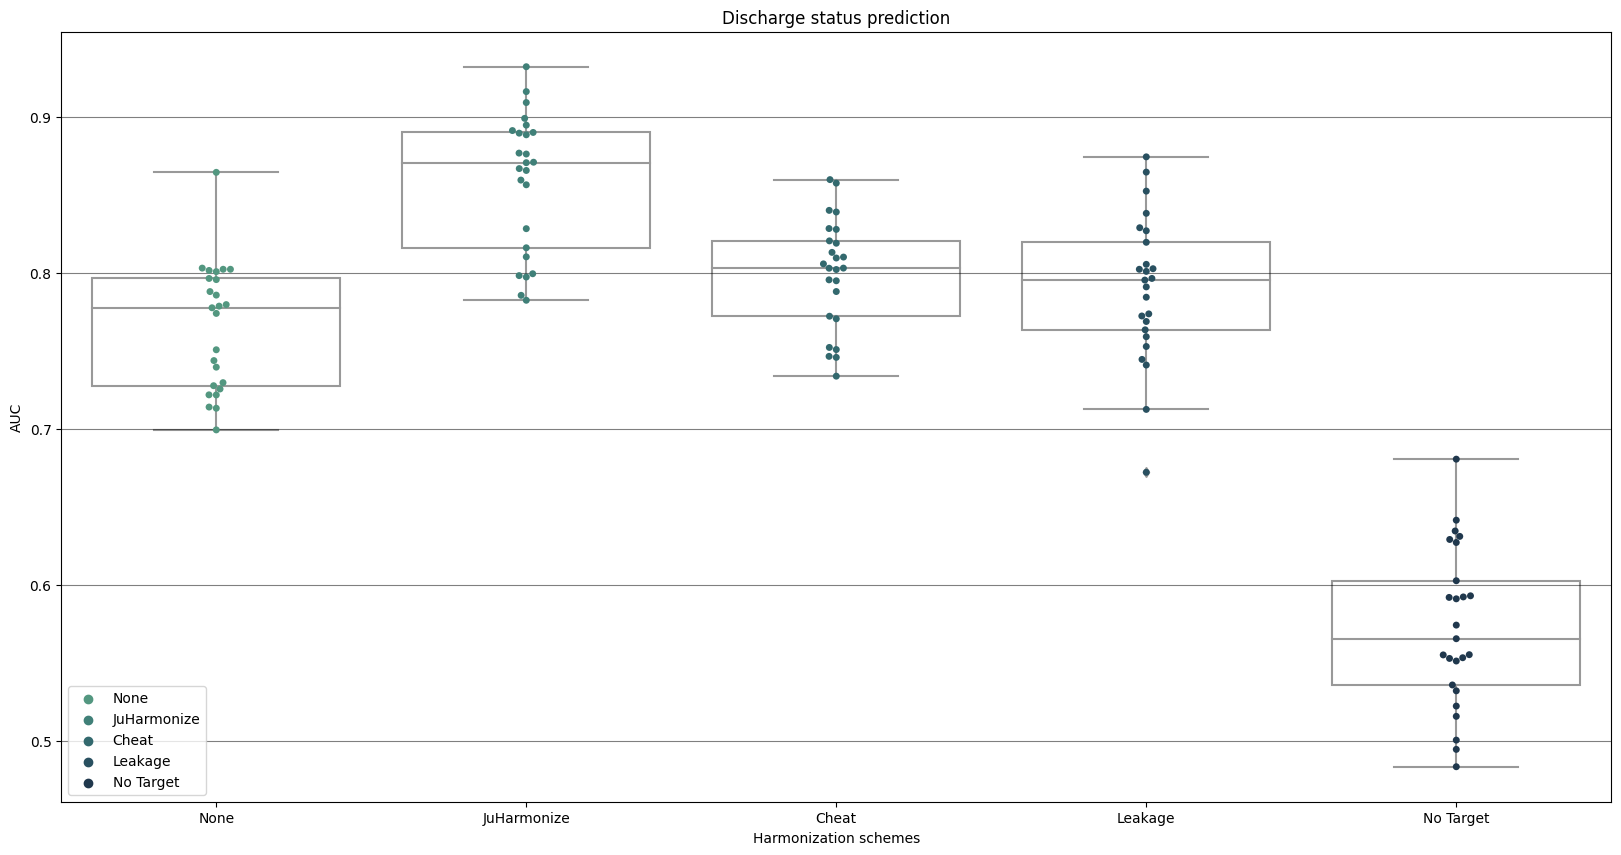

In [4]:
data_dir = "/home/nnieto/Nico/Harmonization/harmonize_project/scratch/output/results/sepsis_classification_eicu/"
data = pd.read_csv(data_dir+"eiCU_results_dependance.csv")
models_to_plot = ["JuHarmonize Test", "Cheat Test", "Leakage Test", "None Test","No Target Test"]

# Select methods to plot
data = data[data["Model"].isin(models_to_plot)]
data["Model"].replace({"JuHarmonize Test": "JuHarmonize",
                                "Cheat Test": "Cheat",
                                "Leakage Test": "Leakage",
                                "No Target Test": "No Target",
                                "None Test": "None"}, inplace=True)
models_to_plot = ["None","JuHarmonize", "Cheat", "Leakage", "No Target"]

data.rename(columns={"Model":"Harmonization Schemes"}, inplace=True)
harm_modes = models_to_plot
metric_to_plot = "AUC"
import matplotlib.pyplot as plt
# Plot
# Plot
pal = sbn.cubehelix_palette(5, rot=-.5, light=0.5, dark=0.2)
_, ax = plt.subplots(1, 1, figsize=[20, 10])
sbn.swarmplot(
    data=data,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    palette=pal,
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax
)
sbn.boxplot(
    data=data, color="w", zorder=1,
    x="Harmonization Schemes", y=metric_to_plot, hue="Harmonization Schemes",
    order=harm_modes,
    hue_order=harm_modes, dodge=False, ax=ax, palette=["w"]*len(harm_modes)
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[:len(harm_modes)], labels[:len(harm_modes)],
          loc='lower left')
plt.ylabel(metric_to_plot)

plt.ylabel(metric_to_plot)
plt.xlabel("Harmonization schemes")
plt.title("Discharge status prediction")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

In [26]:
table = pd.DataFrame(columns=harm_modes, index=["AUC", "Balanced ACC", "F1"])
results = data
# Iterate over each mode
for mode in harm_modes:
    resut_mode = results[results["Harmonization Schemes"] == mode]
    final_stat = resut_mode.mean(numeric_only=True)
    table[mode] = round(final_stat["AUC"],4),round(final_stat["Balanced ACC"]*100,4),round(final_stat["F1"],4)

print(table)

                 None  JuHarmonize    Cheat  Leakage  No Target
AUC            0.7227       0.7101   0.7029   0.6907     0.7198
Balanced ACC  66.8861      66.1457  65.2529  64.7572    66.4240
F1             0.6250       0.6295   0.6133   0.6091     0.6211


# Supplementary
## Age regression

In [ ]:
data = results.copy()
harm_modes = ["JuHarmonize", "Cheat", "Leakage", "None", "No Target"]
data["Harmonization Scheme"].replace({"juharmonize": "JuHarmonize",
                                "leak": "Leakage",
                                "none": "None",
                                "cheat": "Cheat",
                                "notarget": "No Target"}, inplace=True)


data["site"].replace({  0: "AOMIC-ID1000",
                        1: "eNKI",
                        2: "CamCAN",
                        3: "1000Brains"}, inplace=True)



hue_order = ['AOMIC-ID1000', 'eNKI', 'CamCAN', '1000Brains',]
for harm_to_plot in harm_modes:
    data_to_plot = data[data["Harmonization Scheme"] == harm_to_plot]
    fig, ax = plt.subplots(1, 1, figsize=[20, 10])
    pal = sbn.cubehelix_palette(5, rot=-.15, light=0.85, dark=0.3)
    sbn.scatterplot(
        data=data_to_plot,
        x="y_true", y="y_pred", hue="site", hue_order=hue_order
    )
    plt.ylabel("Predicted Age")
    MAE = mean_absolute_error(data_to_plot["y_true"],data_to_plot["y_pred"])
    plt.title(harm_to_plot + " - Age Prediction - MAE: " + str(MAE))
    plt.xlabel("True Age")
    age_range_y = [0,95]
    grid_distance = 10
    plt.yticks(np.arange(age_range_y[0], age_range_y[1], grid_distance))
    plt.grid(alpha=0.5, which="both", axis="y", c="black", linestyle="--")
    plt.legend([],framealpha=0)
    age_range = [18,80]
    plt.xlim(age_range)

    plt.ylim(age_range_y)
    sbn.lineplot(x=age_range, y=age_range)
    plt.show()



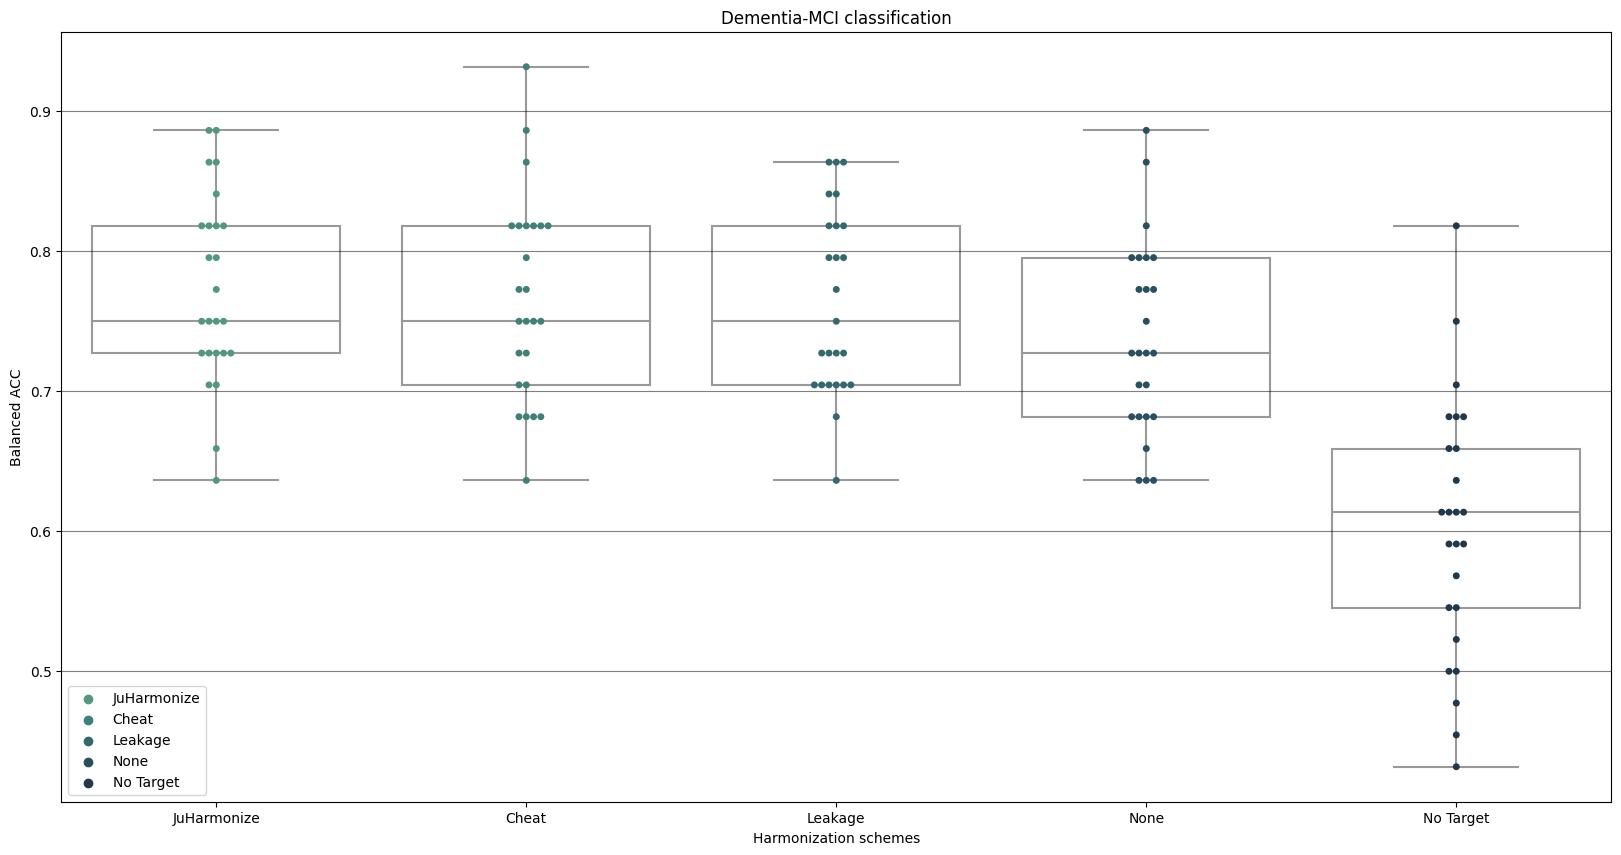

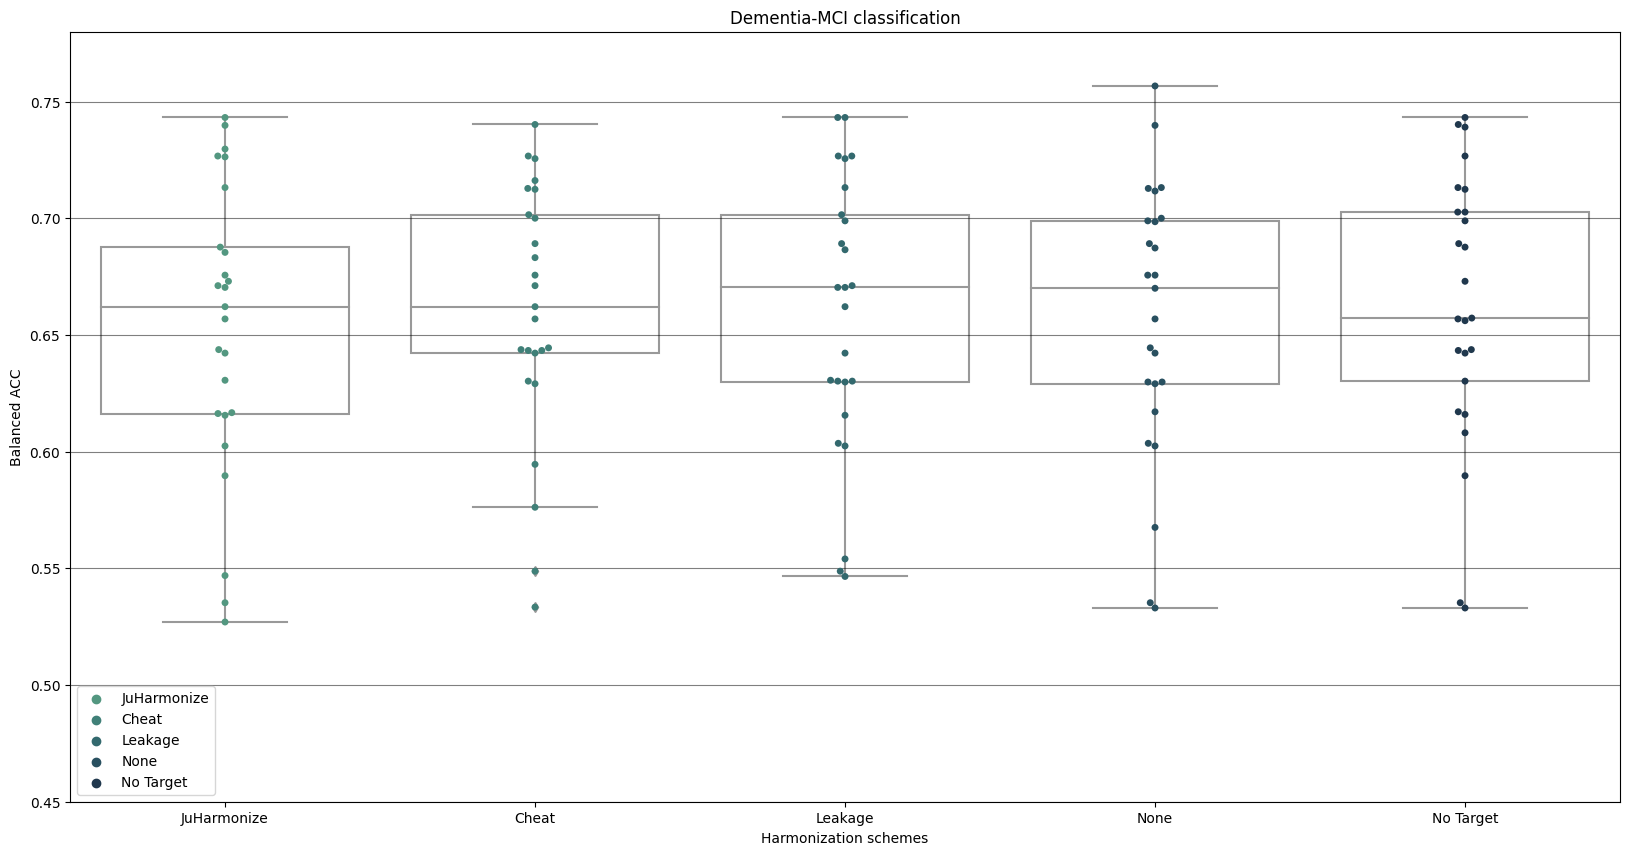

# QC

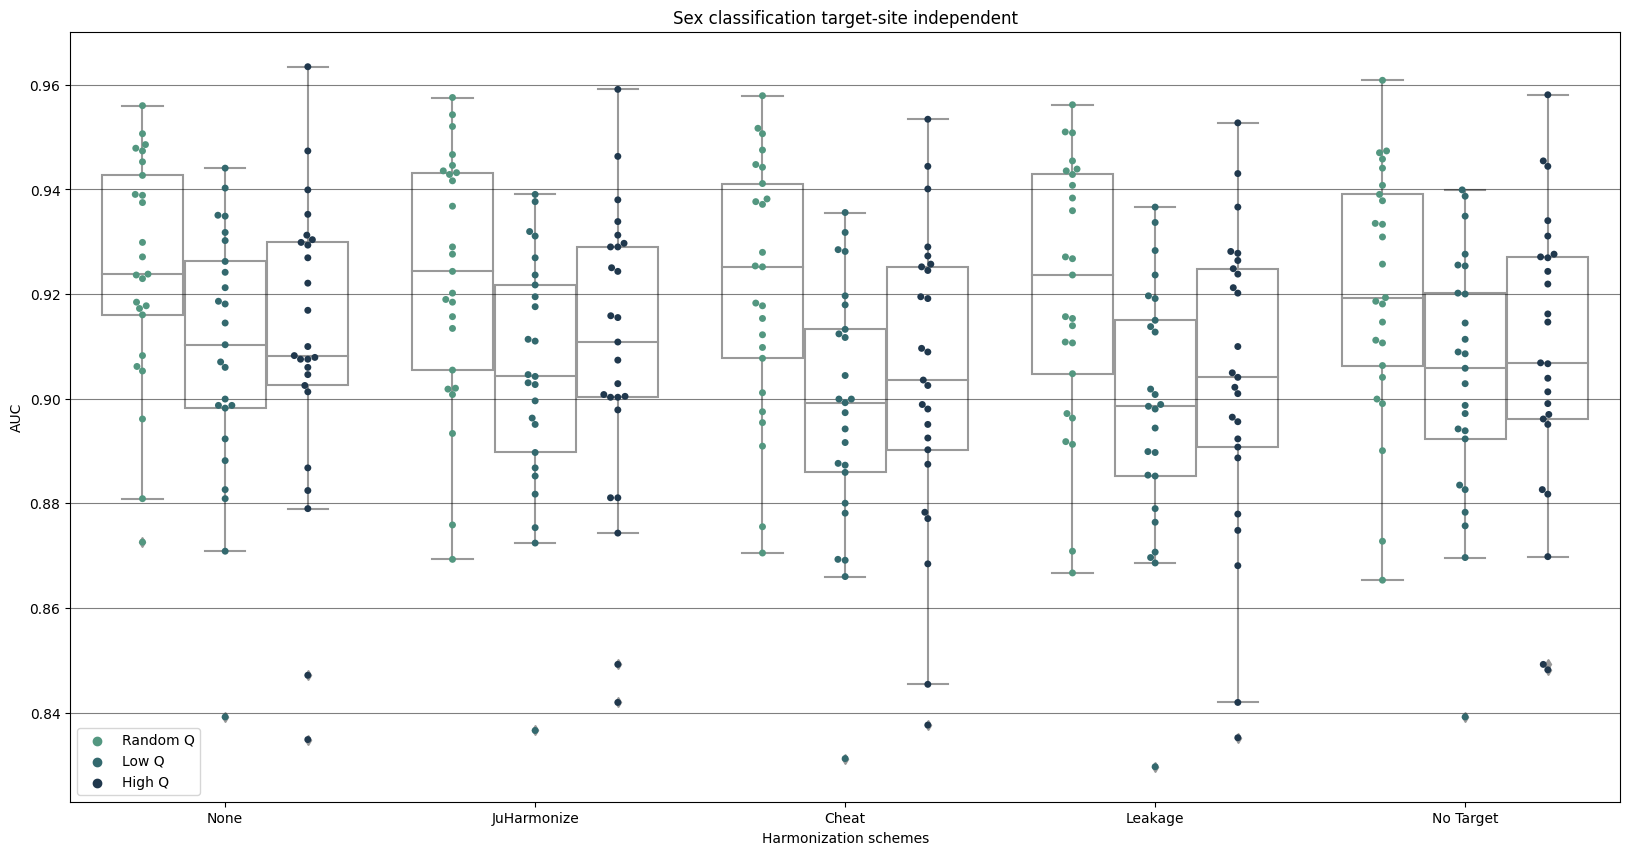

In [19]:
data_dir = "/home/nnieto/Nico/Harmonization/harmonize_project/scratch/output/qc/"
data_h = pd.read_csv(data_dir+"sex_classification_independant_high_qc.csv")
data_h["Quality"] = "High Q"
data_r = pd.read_csv(data_dir+"sex_classification_independant_random_qc.csv")
data_r["Quality"] = "Random Q"
data_l = pd.read_csv(data_dir+"sex_classification_independant_low_qc.csv")
data_l["Quality"] = "Low Q"

data = pd.concat([data_r,data_l,data_h])
models_to_plot = ["JuHarmonize Test", "Cheat Test", "Leakage Test", "None Test","No Target Test"]

# Select methods to plot
data = data[data["Model"].isin(models_to_plot)]
data["Model"].replace({"JuHarmonize Test": "JuHarmonize",
                                "Cheat Test": "Cheat",
                                "Leakage Test": "Leakage",
                                "No Target Test": "No Target",
                                "None Test": "None"}, inplace=True)
models_to_plot = ["None","JuHarmonize", "Cheat", "Leakage", "No Target"]

data.rename(columns={"Model":"Harmonization Schemes"}, inplace=True)
harm_modes = models_to_plot
metric_to_plot = "AUC"
hue_order = ["Random Q","Low Q","High Q"]
import matplotlib.pyplot as plt
# Plot
# Plot
pal = sbn.cubehelix_palette(3, rot=-.5, light=0.5, dark=0.2)
_, ax = plt.subplots(1, 1, figsize=[20, 10])
sbn.swarmplot(
    data=data,
    x="Harmonization Schemes", y=metric_to_plot, hue="Quality",
    palette=pal,
    order=harm_modes,
    hue_order=hue_order, dodge=True, ax=ax
)
sbn.boxplot(
    data=data, color="w", zorder=1,
    x="Harmonization Schemes", y=metric_to_plot, hue="Quality",
    order=harm_modes,
    hue_order=hue_order, dodge=True, ax=ax, palette=["w"]*len(harm_modes)
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[:len(hue_order)], labels[:len(hue_order)],
          loc='lower left')
plt.ylabel(metric_to_plot)

plt.ylabel(metric_to_plot)
plt.xlabel("Harmonization schemes")
plt.title("Sex classification target-site independent")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()

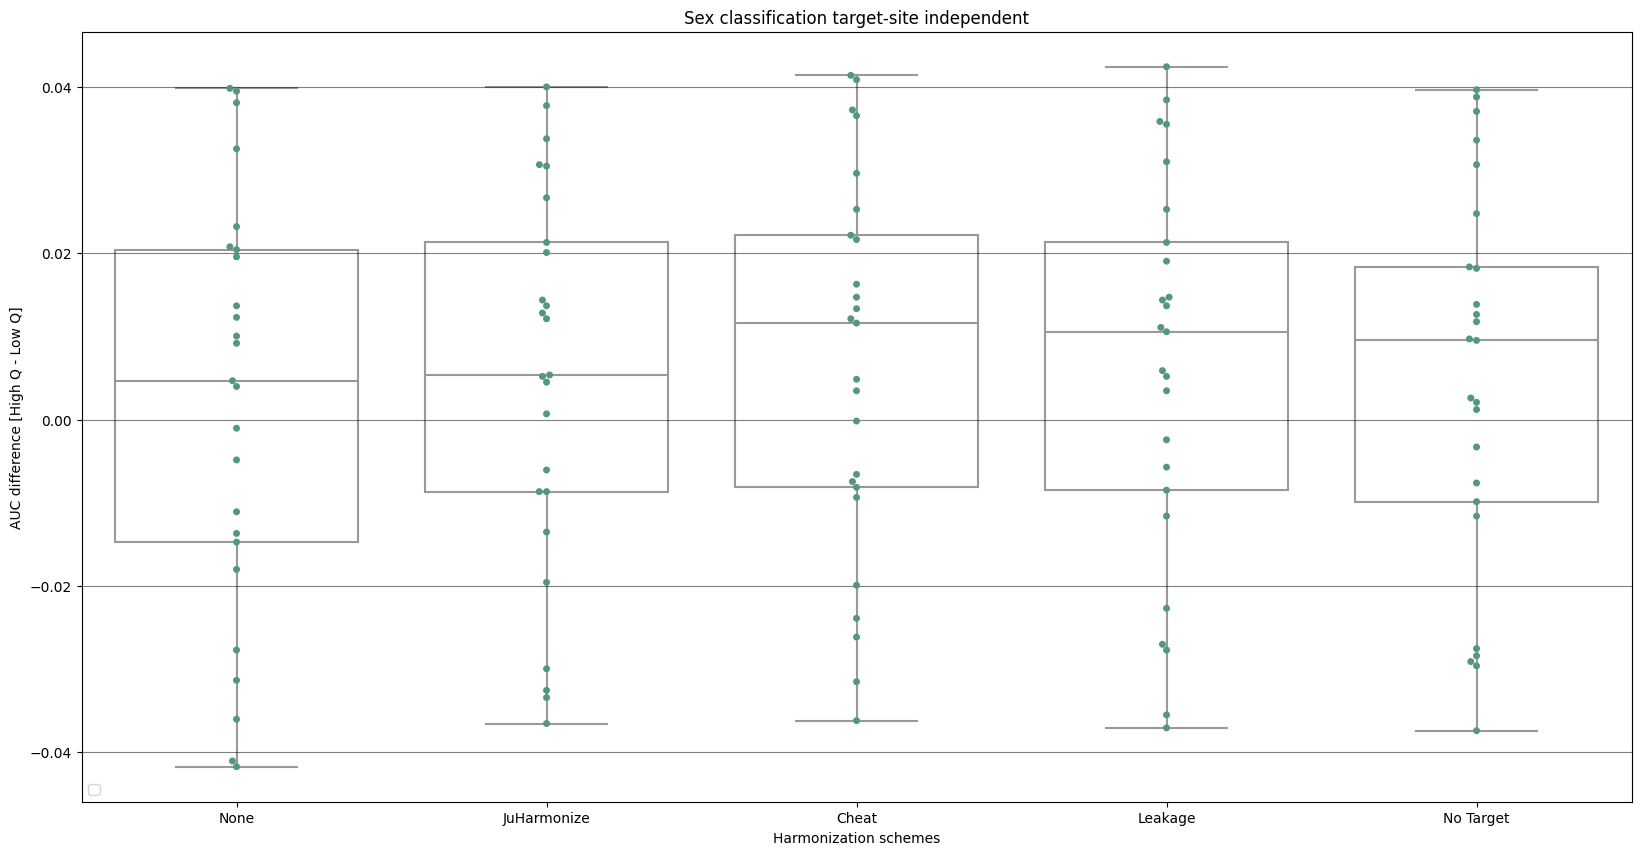

In [25]:
data_dir = "/home/nnieto/Nico/Harmonization/harmonize_project/scratch/output/qc/"
data_h = pd.read_csv(data_dir+"sex_classification_independant_high_qc.csv")
data_h["Quality"] = "High Q"
data_r = pd.read_csv(data_dir+"sex_classification_independant_random_qc.csv")
data_r["Quality"] = "Random Q"
data_l = pd.read_csv(data_dir+"sex_classification_independant_low_qc.csv")
data_l["Quality"] = "Low Q"

data_l["AUC-diff"] = data_h["AUC"] - data_l["AUC"]

data = pd.concat([data_l])
models_to_plot = ["JuHarmonize Test", "Cheat Test", "Leakage Test", "None Test","No Target Test"]

# Select methods to plot
data = data[data["Model"].isin(models_to_plot)]
data["Model"].replace({"JuHarmonize Test": "JuHarmonize",
                                "Cheat Test": "Cheat",
                                "Leakage Test": "Leakage",
                                "No Target Test": "No Target",
                                "None Test": "None"}, inplace=True)
models_to_plot = ["None","JuHarmonize", "Cheat", "Leakage", "No Target"]

data.rename(columns={"Model":"Harmonization Schemes"}, inplace=True)
harm_modes = models_to_plot
metric_to_plot = "AUC-diff"
hue_order = ["Random Q","Low Q","High Q"]
hue_order = ["Low Q"]

import matplotlib.pyplot as plt
# Plot
# Plot
pal = sbn.cubehelix_palette(1, rot=-.5, light=0.5, dark=0.2)
_, ax = plt.subplots(1, 1, figsize=[20, 10])
sbn.swarmplot(
    data=data,
    x="Harmonization Schemes", y=metric_to_plot, hue="Quality",
    palette=pal,
    order=harm_modes,
    hue_order=hue_order, dodge=True, ax=ax
)
sbn.boxplot(
    data=data, color="w", zorder=1,
    x="Harmonization Schemes", y=metric_to_plot, hue="Quality",
    order=harm_modes,
    hue_order=hue_order, dodge=True, ax=ax, palette=["w"]*len(harm_modes)
)
handles, labels = ax.get_legend_handles_labels()

ax.legend([],
          loc='lower left',)
plt.ylabel(metric_to_plot)

plt.ylabel("AUC difference [High Q - Low Q]")
plt.xlabel("Harmonization schemes")
plt.title("Sex classification target-site independent")
plt.grid(alpha=0.5, axis="y", c="black")
plt.show()